Note: mode collapse unavoidable with basic GAN. Can possibly mitigate with unrolled GAN.

In [70]:
import torch, torch.nn as nn, torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def sample_P_16modes(n, spacing=3.0, jitter=0.0, cov_scale=0.1, device=device):
    """
    Draw n samples from an equal-weight 16-mode GMM on a 4x4 grid.
    Centers are at {(i,j): i,j in {-1.5,-0.5,0.5,1.5} * spacing}.
    cov_scale is the per-mode variance factor (isotropic).
    jitter adds small random shifts to each center (for non-perfect grid).
    """
    # 4x4 grid coordinates
    coords_1d = torch.tensor([-1.5, -0.5, 0.5, 1.5], device=device) * spacing
    M = torch.stack(torch.meshgrid(coords_1d, coords_1d, indexing="xy"), dim=-1).reshape(-1, 2)  # (16,2)
    if jitter > 0:
        M = M + jitter * torch.randn_like(M)

    # equal mixture
    k = M.size(0)  # 16
    # multinomial counts for each mode
    probs = torch.full((k,), 1.0 / k, device=device)
    counts = torch.multinomial(probs, num_samples=n, replacement=True).bincount(minlength=k)

    xs = []
    for i, c in enumerate(counts.tolist()):
        if c == 0: continue
        xs.append(M[i].unsqueeze(0) + math.sqrt(cov_scale) * torch.randn(c, 2, device=device))
    X = torch.cat(xs, dim=0)
    idx = torch.randperm(X.size(0), device=device)
    return X[idx]

class GNet(nn.Module):
    def __init__(self, z_dim=16, x_dim=2, hidden=(100, 100, 100), act=nn.ReLU):
        super().__init__()
        layers, d = [], z_dim
        for h in hidden:
            layers += [nn.Linear(d, h), act()]
            d = h
        layers += [nn.Linear(d, x_dim)]
        self.net = nn.Sequential(*layers)
        
    def forward(self, z):
        output = self.net(z)
        return output
    
class DNet(nn.Module):
    def __init__(self, x_dim=2, hidden=(100, 100), act=nn.ReLU):
        super().__init__()
        layers, d = [], x_dim
        for h in hidden:
            layers += [nn.Linear(d, h), act()]
            d = h
        layers += [nn.Linear(d, 1), nn.Sigmoid()]
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
    
def clamped_log(x):
    return torch.clamp(torch.log(x), min=-100)

def g_loss(x_fake, d):
    # return nn.BCELoss()(d(x_fake), torch.ones(x_fake.size(0)).unsqueeze(1))
    return -clamped_log(d(x_fake)).mean()

def d_loss(x_real, x_fake, d):
    # return (nn.BCELoss()(d(x_real), torch.ones(x_real.size(0)).unsqueeze(1)) + nn.BCELoss()(d(x_fake), torch.zeros(x_real.size(0)).unsqueeze(1))) / 2
    return -0.5 * (clamped_log(d(x_real)) + clamped_log(1 - d(x_fake))).mean()

def train(n_real=100_000, batch_size=1024, epochs=50, lr_g=1e-7, lr_d=1e-7, k=1, z_dim=16, seed=0):
    torch.manual_seed(seed)
    x_real = sample_P_16modes(n_real)
    dl = DataLoader(TensorDataset(x_real), batch_size=batch_size, shuffle=True, drop_last=True)
    g = GNet(z_dim=z_dim).to(device)
    d = DNet().to(device)
    opt_g = torch.optim.SGD(g.parameters(), lr=lr_g)
    opt_d = torch.optim.SGD(d.parameters(), lr=lr_d)
    # opt_g = torch.optim.Adam(g.parameters(), lr=lr_g, betas=(0.5, 0.999))
    # opt_d = torch.optim.Adam(d.parameters(), lr=lr_d, betas=(0.5, 0.999))
    def sample_fake(m):
        z = torch.randn(m, z_dim, device=device)
        return g(z)
    running_loss_g = 0
    running_loss_d = 0
    for epoch in range(1, epochs + 1):
        g.train()
        d.train()
        for (x,) in dl:
            x = x.to(device)
            m = batch_size
            for _ in range(k):
                x_fake = sample_fake(m).detach()
                loss_d = d_loss(x, x_fake, d)
                opt_d.zero_grad()
                loss_d.backward()
                running_loss_d += loss_d
                opt_d.step()
            x_fake = sample_fake(m).detach()
            loss_g = g_loss(x_fake, d)
            opt_g.zero_grad()
            loss_g.backward()
            running_loss_g += loss_g
            opt_g.step()
        if epoch % 5 == 0:
            print(f'[{epoch}] Generator loss: {running_loss_g / 2}')
            print(f'[{epoch}] Discriminator loss: {running_loss_d / 2 / k}')
            running_loss_g = 0
            running_loss_d = 0
    return g, d


In [71]:
if __name__ == '__main__':
    g, d = train()

[5] Generator loss: 146.7059326171875
[5] Discriminator loss: 154.85997009277344
[10] Generator loss: 146.70555114746094
[10] Discriminator loss: 154.85643005371094
[15] Generator loss: 146.704345703125
[15] Discriminator loss: 154.85462951660156
[20] Generator loss: 146.7041778564453
[20] Discriminator loss: 154.8474884033203
[25] Generator loss: 146.70333862304688
[25] Discriminator loss: 154.8457489013672
[30] Generator loss: 146.70286560058594
[30] Discriminator loss: 154.8402099609375
[35] Generator loss: 146.7023468017578
[35] Discriminator loss: 154.8358917236328
[40] Generator loss: 146.70166015625
[40] Discriminator loss: 154.83070373535156
[45] Generator loss: 146.70086669921875
[45] Discriminator loss: 154.8268280029297
[50] Generator loss: 146.70074462890625
[50] Discriminator loss: 154.82574462890625


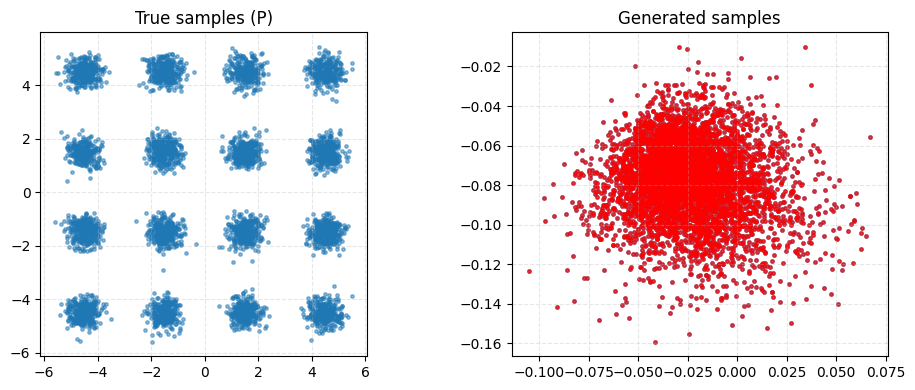

In [72]:
import matplotlib.pyplot as plt

def visualize_results(g, d, n_real=5000, n_fake=5000):
    x_real = sample_P_16modes(n_real).cpu()
    assert(isinstance(g.net[0], nn.Linear))
    z_dim = next(g.net[0].parameters()).shape[1]
    z = torch.randn(n_fake, z_dim, device=device)
    x_fake = g(z).detach().cpu()
    red_idx = d(x_fake).squeeze() > 0.5
    # print(d(x_fake).mean().item(), d(x_fake).std().item())
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(x_real[:,0], x_real[:,1], s=6, alpha=0.5, label="True")
    ax[0].set_title("True samples (P)")
    ax[0].set_aspect("equal")
    ax[0].grid(True, ls="--", alpha=0.3)
    ax[1].scatter(x_fake[:,0], x_fake[:,1], s=6, alpha=0.6, label="Generated")
    ax[1].scatter(x_fake[red_idx,0], x_fake[red_idx,1], s=6, alpha=0.6, c="red", label="Generated")
    ax[1].set_title(f"Generated samples")
    ax[1].set_aspect("equal")
    ax[1].grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_results(g, d)